# Qwen3-30B-A3B Load Balancing

## Import Libraries

In [ ]:
import math
import time
import random
import types
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from datasets import load_dataset
from torch.profiler import profile, record_function, ProfilerActivity
from transformers import AutoModelForCausalLM, AutoTokenizer
from dataclasses import dataclass
from typing import Dict, List
from collections import defaultdict

## Load Model

In [ ]:
model_name = "Qwen/Qwen3-30B-A3B"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype=torch.bfloat16
).cuda()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/963 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/531 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

## Dataset and Inference Helpers

In [ ]:
def load_mmlu_subset(subject="all", sample_size=50, seed=42):
    """
    load a repeatable random subset of MMLU
    """
    random.seed(seed)

    # load the entire dataset
    dataset = load_dataset("cais/mmlu", subject, split="test")

    # shuffle and select subset
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    subset_indices = indices[:sample_size]

    return dataset.select(subset_indices)

def format_mmlu_prompt(example):
    """
    format question prompt with a primer at the end
    """
    prompt = f"Question: {example['question']}\n"
    for i, choice in enumerate(["A", "B", "C", "D"]):
        prompt += f"{choice}. {example['choices'][i]}\n"
    # prime the LLM to begin answering with the letter corresponding to its choice
    prompt += "\nAnswer:"
    return prompt

def evaluate_batch(examples, model, tokenizer):
    """
    evaluate a local model on a batch of prompts
    """
    # set pad token if doesn't exist
    # need to pad because sequence lengths must be identical in batch
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # pad on left to ensure the last token is aligned across the batch
    tokenizer.padding_side = "left"

    # format all prompts in batch
    prompts = [format_mmlu_prompt(ex) for ex in examples]

    # prepare inputs with padding
    inputs = tokenizer(prompts, return_tensors="pt", padding=True).to(model.device)

    # store mask on the model for access via MoE blocks
    model.current_padding_mask = (inputs["attention_mask"] == 0)

    choice_tokens = ["A", "B", "C", "D"]
    choice_ids = [tokenizer.encode(token, add_special_tokens=False)[-1] for token in choice_tokens]

    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)

    # measure event time
    start_event.record()
    with torch.inference_mode(): # inference_mode is faster than no_grad
        # unpack inputs kwargs ("input_ids" and "attention_mask")
        outputs = model(**inputs)
        # grab logits for last token position for every sequence in batch
        logits = outputs.logits[:, -1, :]
    end_event.record()

    # must synchronize because GPU is async
    torch.cuda.synchronize()

    # extract logits for choice tokens across entire batch
    choice_logits = logits[:, choice_ids] # keep first dimension (batch), select choice_ids from second dim

    # get argmax for each row (dim=1)
    prediction_indices = torch.argmax(choice_logits, dim=1).tolist() # calling .tolist() implicitly syncs, but it's good practice to explicitly sync

    # map predictions to labels
    predictions = [choice_tokens[idx] for idx in prediction_indices]

    # measure total batch time
    total_time = start_event.elapsed_time(end_event)

    return predictions, total_time

def evaluate_online(example, model, tokenizer):
    """
    evaluate a local model on a single prompt
    """
    prompt = format_mmlu_prompt(example)

    # prepare inputs and choice tokens
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    choice_tokens = ["A", "B", "C", "D"]
    choice_ids = [tokenizer.encode(token, add_special_tokens=False)[-1] for token in choice_tokens]

    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)

    # measure event time
    start_event.record()
    with torch.inference_mode(): # inference_mode is faster than no_grad
        logits = model(**inputs).logits[:, -1, :]
    end_event.record()

    # must synchronize because GPU is async
    torch.cuda.synchronize()

    # extract logits for choice tokens
    choice_logits = logits[0, choice_ids] # keep first dimension (batch), select choice_ids from second dim
    prediction_idx = torch.argmax(choice_logits).item() # calling .item() implicitly syncs, but it's good practice to explicitly sync

    # return tuple of selected answer and TTFT
    return choice_tokens[prediction_idx], start_event.elapsed_time(end_event)

def get_length_grouped_batches(dataset, tokenizer, batch_size=10):
    """
    return groups of indices of prompts of size batch_size sorted in increasing order of prompt token count
    """
    prompts = [format_mmlu_prompt(ex) for ex in dataset]
    lengths = [len(tokenizer.encode(p, add_special_tokens=False)) for p in prompts] # use quick encoding

    # sort indices by token count
    sorted_indices = [i for i, _ in sorted(enumerate(lengths), key=lambda x: x[1])]

    # create batches
    batches = [sorted_indices[i:i + batch_size] for i in range(0, len(sorted_indices), batch_size)]

    return batches

def warmup(model, tokenizer):
    """
    warm up the model by generating several small outputs
    """
    prompt = "Explain the theory of relativity in one sentence."
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

    for _ in range(3):
        _ = model.generate(**inputs, max_new_tokens=1)

def remove_all_hooks(model):
    """
    explicitly remove all hooks in the model
    """
    for name, module in model.named_modules():
        # clear forward hooks
        module._forward_hooks.clear()
        module._forward_pre_hooks.clear()

        # clear backward hooks
        module._backward_hooks.clear()
        module._backward_pre_hooks.clear()

def list_hooks(model, verbose=False):
    """
    list all existing hooks in the model
    """
    cnt = 0
    for name, module in model.named_modules():
        if module._forward_hooks or module._forward_pre_hooks or module._backward_hooks:
            if verbose:
                print(f"Module: {name}")
                for hook_id, hook in module._forward_hooks.items():
                    print(f"  - Forward Hook (ID: {hook_id}): {hook}")
                for hook_id, hook in module._forward_pre_hooks.items():
                    print(f"  - Forward Pre-Hook (ID: {hook_id}): {hook}")
                for hook_id, hook in module._backward_hooks.items():
                    print(f"  - Backward Hook (ID: {hook_id}): {hook}")
            cnt += 1
    if cnt > 0:
        print(f"Model has {cnt} hooks")
    else:
        print("Model has no hooks")

## Custom Forward Function + Helpers

In [ ]:
def optimized_forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
    """
    drop-in replacement forward function for Qwen3MoeSparseMoeBlock
    efficiently balances padding token distribution across experts
    """
    batch_size, sequence_length, hidden_dim = hidden_states.shape
    # flatten 3D hidden_states tensor into 2D (batch_size * sequence_length, hidden_dim)
    hidden_states_reshaped = hidden_states.view(-1, hidden_dim)
    # grab batch_size * sequence_length as num_total_tokens
    num_total_tokens = hidden_states_reshaped.size(0)

    # get padding mask (opposite of attention mask) from parent_model (set during swap_forward)
    mask = getattr(self.parent_model, "current_padding_mask", None)
    if mask is not None:
        is_padding = mask.view(-1)
    else:
        # fallback: assume all tokens are real (not padding)
        is_padding = torch.zeros(num_total_tokens, device=hidden_states.device, dtype=torch.bool)

    # call gate function and store routing weights + selected experts
    _, routing_weights, selected_experts = self.gate(hidden_states_reshaped)

    # safely access number of experts and top k values
    num_experts = self.num_experts if hasattr(self, 'num_experts') else self.parent_model.num_experts
    top_k = getattr(self, 'top_k', getattr(self, 'num_experts_per_tok', 8)) # fallback: assume top k = 8

    # grab indices of padding tokens (access 0th element because torch.where returns a tuple)
    padding_indices = torch.where(is_padding != 0)[0]
    # count number of elements in padding_indices
    num_padding = padding_indices.numel()

    if num_padding > 0:
        real_mask = ~is_padding
        # filter out padding and get expert assignments
        real_expert_assignments = selected_experts[real_mask].view(-1)
        # calculate expert load from real tokens
        current_load = torch.bincount(real_expert_assignments, minlength=num_experts).float()

        # total number of padding tokens we need to redistribute
        total_slots_to_fill = num_padding * top_k

        # calculate how far from average each expert's capacity is
        avg_target = (current_load.sum() + total_slots_to_fill) / num_experts
        deficits = (avg_target - current_load).clamp(min=0) # clamp to avoid negative capacity

        # in case model is already perfectly balanced, fallback to uniform distribution
        if deficits.sum() == 0:
            deficits = torch.ones_like(deficits)

        # allocate tokens proportionally based on the needs of each expert
        scale_factor = total_slots_to_fill / deficits.sum()
        fill_counts = (deficits * scale_factor).floor() # floor to ensure integer capacity

        # fix rounding errors from floor
        remainder = int(total_slots_to_fill - fill_counts.sum())

        # distribute remainder to experts with highest original deficits
        if remainder > 0:
            _, top_indices = torch.topk(deficits, k=remainder)
            fill_counts[top_indices] += 1

        # create list of expert IDs based on fill_counts
        new_padding_expert_ids = torch.repeat_interleave(
            torch.arange(num_experts, device=hidden_states.device),
            fill_counts.long()
        )

        # overwrite original padding token routing with new load balanced routing
        selected_experts[padding_indices] = new_padding_expert_ids.view(num_padding, top_k)
        # set equal importance to new padding assignments
        routing_weights[padding_indices] = 1.0 / top_k

    # set selected experts attribute
    self.current_selected_experts = selected_experts

    # compute outputs using load balanced token routing
    final_hidden_states = self.experts(hidden_states_reshaped, selected_experts, routing_weights)

    return final_hidden_states.reshape(batch_size, sequence_length, hidden_dim)

def swap_forward(model, new_forward_fn):
    """
    swaps forward function in every MoE block
    """
    swapped_count = 0

    for i, layer in enumerate(model.model.layers):
        moe_block = layer.mlp
        # print(f"Patching module at {id(moe_block)}")

        if hasattr(moe_block, 'gate'):
            # attach reference to parent model
            moe_block.parent_model = model

            # store original forward on the block itself if not already done
            if not hasattr(moe_block, 'original_forward'):
                moe_block.original_forward = moe_block.forward

            # bind new function to this block instance
            moe_block.forward = types.MethodType(new_forward_fn, moe_block)
            swapped_count += 1

    print(f"Swapped forward for {swapped_count} MoE blocks")

def restore_forward(model):
    """
    restores original forward method for every MoE block
    """
    restored_count = 0
    for i, layer in enumerate(model.model.layers):
        moe_block = layer.mlp
        if hasattr(moe_block, 'original_forward'):
            # restore original forward function
            moe_block.forward = moe_block.original_forward

            # delete original forward attribute
            del moe_block.original_forward
            restored_count += 1

    print(f"Restored original forward for {restored_count} MoE blocks")

## Evaluation Data Structures

In [ ]:
@dataclass
class BatchRun:
    """
    stores info about a single eval run
    """
    evals: List[str] # names of the evals (e.g. unsorted_default, sorted_default, unsorted_optimized, sorted_optimized)
    sorted_flags: List[bool] # whether or not data is sorted for a certain eval
    opt_flags: List[bool] # whether or not to use optimized forward function
    batch_size: int = 10
    num_batches: int = 10

    def __post_init__(self):
        length = len(self.evals)
        assert all([len(l) == length for l in [self.sorted_flags, self.opt_flags]]), "Lengths of input lists do not match"

class Evaluation:
    """
    runs evals and generates visuals over several BatchRuns
    """
    def __init__(self, model, tokenizer, runs: List[BatchRun]):
        self.model = model
        self.tokenizer = tokenizer
        self.runs = runs
        self.monitors = [{name: MoEMonitor(self.model, optimized=opt) for name, opt in zip(run.evals, run.opt_flags)} for run in runs]
        self.accuracies = [defaultdict(list) for _ in range(len(runs))]
        self.cvs = [{} for _ in range(len(runs))]
        self.batch_times = [defaultdict(list) for _ in range(len(runs))]

    def evaluate(self):
        """
        perform evaluations based on BatchRuns specified in self.runs
        """
        # warm up model
        warmup(model, tokenizer)

        # remove all existing hooks so there are no conflicts
        remove_all_hooks(self.model)
        list_hooks(self.model)

        for i, run in enumerate(self.runs):
            print(f"\n============Begin run {i+1} (Batch={run.batch_size}x{run.num_batches})============")

            # load batches from dataset
            batch_size = run.batch_size
            num_batches = run.num_batches
            full_subset = load_mmlu_subset(sample_size=batch_size * num_batches)

            # create sorted and unsorted batches
            batch_indices = get_length_grouped_batches(full_subset, tokenizer, batch_size=batch_size)
            sorted_batches = [[full_subset[i] for i in indices] for indices in batch_indices]
            unsorted_batches = [[full_subset[i * batch_size + j] for j in range(batch_size)] for i in range(num_batches)]

            for j, eval in enumerate(run.evals):
                print(f"\n------------Begin eval {eval}------------")
                self.monitors[i][eval].attach()

                # check if need to swap forward function
                if run.opt_flags[j]:
                    swap_forward(self.model, optimized_forward)

                # use sorted or unsorted based on flags
                batches = sorted_batches if run.sorted_flags[j] else unsorted_batches

                # run batch inference
                for batch in batches:
                    choices, total_batch_time = evaluate_batch(batch, model, tokenizer)
                    # store batch times
                    self.batch_times[i][eval].append(total_batch_time)

                    # store accuracies
                    labels = ["A", "B", "C", "D"]
                    ground_truths = [labels[ex["answer"]] for ex in batch] # can precompute these
                    self.accuracies[i][eval].append(np.equal(ground_truths, choices).sum() / batch_size)

                # store CVs
                self.cvs[i][eval] = self.monitors[i][eval].stats.get_all_layer_cvs()

                # restore forward function
                if run.opt_flags[j]:
                    restore_forward(self.model)

                self.monitors[i][eval].remove()

    def _base_plot(self, data_source, title_suffix, ylabel, x_label_type="layer", colors=["#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78"], cols=2):
        """
        generic plotting function
        data_source: List[Dict] where data_source[run_idx][eval_name] contains the y-values
        x_label_type: "layer" (for MoE layer indices) or "batch" (for iteration indices)
        """
        num_runs = len(self.runs)
        rows = math.ceil(num_runs / cols)
        fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows), squeeze=False)

        # standardize axes into a flat list
        axes = axes.flatten()

        # determine global y limit
        all_values = [v for run_data in data_source for v in run_data.values()]
        flat_values = [item for sublist in all_values for item in sublist]
        max_yval = max(flat_values) if flat_values else 1.0

        for i, run in enumerate(self.runs):
            ax = axes[i]

            for j, eval_name in enumerate(run.evals):
                y_values = data_source[i][eval_name]
                print(f"Average {ylabel} for {eval_name} (Batch {run.batch_size}x{run.num_batches}): {sum(y_values) / len(y_values):.2f}")
                x_values = range(len(y_values))

                ax.plot(
                    x_values, y_values,
                    label=eval_name,
                    color=colors[j % len(colors)],
                    marker="o" if x_label_type == "layer" else "x",
                    linewidth=2 if x_label_type == "layer" else 1.5,
                    markersize=4,
                    alpha=0.8
                )

            # subplot formatting
            ax.set_title(f"Run {i+1}: Batch {run.batch_size}x{run.num_batches} {title_suffix}", fontsize=12)
            ax.set_ylabel(ylabel, fontsize=10)
            ax.set_ylim(0, max_yval * 1.1)
            ax.legend(frameon=True, fontsize=8)
            ax.grid(True, linestyle="--" if x_label_type == "layer" else ":", alpha=0.4)

            # x-axis logic
            ax.set_xticks(range(0, len(y_values), max(1, len(y_values) // 10)))
            if x_label_type == "layer":
                ax.set_xlabel("Layer Index", fontsize=10)
            else:
                ax.set_xlabel("Batch Index", fontsize=10)

        # clean up empty subplots
        for j in range(i + 1, len(axes)):
            axes[j].axis("off")

        plt.tight_layout()
        return fig, axes

    def plot_cv(self, cols=2):
        """
        plot expert load imbalance (CV) per layer
        """
        return self._base_plot(
            data_source=self.cvs,
            title_suffix="(CV)",
            ylabel="CV",
            x_label_type="layer",
            cols=cols
        )

    def plot_batch_times(self, cols=2):
        """
        plot execution time per batch
        """
        return self._base_plot(
            data_source=self.batch_times,
            title_suffix="(Time)",
            ylabel="Execution Time (ms)",
            x_label_type="batch",
            # colors=["#2d6a4f", "#95d5b2", "#6a0dad", "#b39ddb"],
            cols=cols
        )

    def plot_accuracies(self, cols=2):
        """
        plot accuracy per batch
        """
        return self._base_plot(
            data_source=self.accuracies,
            title_suffix="(Accuracy)",
            ylabel="Accuracy (Proportion)",
            x_label_type="batch",
            # colors=["#b91d1d", "#f87171", "#4b5563", "#9ca3af"],
            cols=cols
        )

class MoELoadStats:
    def __init__(self, distribution):
        assert distribution.ndim == 2, "Distribution must be two-dimensional"
        self.distribution = distribution

    def plot_heatmap(self, title="MoE Token Distribution", save_path="distribution_heatmap.png", cmap="magma"):
        """
        plot heatmap of per-layer per-expert token distribution
        """
        # move pytorch tensor to CPU and convert to numpy array
        data_to_plot = self.distribution.detach().cpu().numpy()
        layers, experts = data_to_plot.shape

        # set width based on expert count
        fig_width = max(12, experts * 0.2)
        plt.figure(figsize=(fig_width, 8))

        # use nearest interpolation
        im = plt.imshow(data_to_plot, aspect='auto', cmap=cmap, interpolation='nearest')

        plt.title(title, fontsize=16, pad=20)
        plt.xlabel('Expert Index', fontsize=24)
        plt.ylabel('Layer Index', fontsize=24)

        # use steps if more than 32 experts
        if experts > 32:
            step = 8 if experts <= 128 else 16
            tick_indices = np.arange(0, experts, step)
            plt.xticks(tick_indices, tick_indices, fontsize=10)
        else:
            plt.xticks(range(experts))

        plt.yticks(range(layers))

        # add grid to distinguish expert boundaries
        plt.gca().set_xticks(np.arange(-.5, experts, 1), minor=True)
        plt.grid(which="minor", color="w", linestyle='-', linewidth=0.5, alpha=0.2)
        plt.tick_params(which="minor", bottom=False, left=False)

        cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
        cbar.set_label('Token Count', rotation=270, labelpad=15)

        plt.tight_layout()
        plt.savefig(save_path, dpi=300)

    def get_layer_imbalance(self, layer_idx: int):
        """
        compute CV (coefficient of variance) for a specific layer
        """
        num_layers = self.distribution.shape[0]

        # ensure valid layer index
        assert 0 <= layer_idx < num_layers, "Invalid layer index"

        layer_data = self.distribution[layer_idx].float()
        return layer_data.std() / (layer_data.mean() + 1e-6)

    def get_all_layer_cvs(self):
        """
        get CV for every layer in the distribution
        """
        num_layers = self.distribution.shape[0]
        return [self.get_layer_imbalance(i).item() for i in range(num_layers)]

class MoEMonitor:
    def __init__(self, model, optimized=False):
        self.model = model
        self.handles = []
        self.optimized = optimized

        self.num_layers = model.config.num_hidden_layers
        self.num_experts = model.config.num_experts

        # initialize stats with tensor of all zeros
        self.stats = MoELoadStats(
            distribution=torch.zeros(
                (self.num_layers, self.num_experts),
                device=model.device,
                dtype=torch.long
            )
        )

    def _gate_hook_fn(self, layer_idx):
        """
        return hook function that is meant for hooking into gate module
        """
        def hook(module, input, output):
            # get router logits, data structure may vary based on architecture
            router_logits = output[0] if isinstance(output, tuple) else output

            # identify which experts were selected
            _, selected_experts = torch.topk(router_logits, k=module.top_k, dim=-1)

            # flatten indices and create ones tensor (gate)
            indices = selected_experts.view(-1)
            ones = torch.ones_like(indices, dtype=torch.long)

            # perform in-place scatter add
            self.stats.distribution[layer_idx].scatter_add_(0, indices, ones)
        return hook

    def _mlp_hook_fn(self, layer_idx):
        """
        return hook function that is meant for hooking into mlp module
        """
        def hook(module, input, output):
            # look for selected experts attribute
            selected_experts = getattr(module, "current_selected_experts", None)
            # print(f"Hooking module at {id(module)}")
            if selected_experts is None:
                print(f"Layer {layer_idx}: 'current_selected_experts' attribute not found on {type(module)}")
                return

            # flatten indices and create ones tensor (mlp)
            indices = selected_experts.view(-1)
            ones = torch.ones_like(indices, dtype=torch.long)

            # perform in-place scatter add
            self.stats.distribution[layer_idx].scatter_add_(0, indices, ones)
        return hook

    def attach(self):
        """
        attaches hooks to the mlp/gate of every MoE layer
        """
        for layer_idx in range(self.num_layers):
            if self.optimized: # need to hook onto mlp layer because that's where token rerouting happens
                mlp_module = self.model.model.layers[layer_idx].mlp
                handle = mlp_module.register_forward_hook(self._mlp_hook_fn(layer_idx))
            else: # otherwise just grab expert selection from gate
                gate_module = self.model.model.layers[layer_idx].mlp.gate
                handle = gate_module.register_forward_hook(self._gate_hook_fn(layer_idx))
            self.handles.append(handle)
        print(f"Monitoring {self.num_layers} MoE layers ({'mlp' if self.optimized else 'gate'})")

    def remove(self):
        """
        safely detaches all hooks
        """
        for handle in self.handles:
            handle.remove()
        self.handles = []
        print("Removed all handles")

## Run Evaluations

### Initial Evaluation (Baseline)

Restored original forward for 0 MoE blocks
Model has no hooks

============Begin run 1 (Batch=8x50)============


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

all/test-00000-of-00001.parquet:   0%|          | 0.00/3.50M [00:00<?, ?B/s]

all/validation-00000-of-00001.parquet:   0%|          | 0.00/408k [00:00<?, ?B/s]

all/dev-00000-of-00001.parquet:   0%|          | 0.00/76.5k [00:00<?, ?B/s]

all/auxiliary_train-00000-of-00001.parqu(…):   0%|          | 0.00/47.5M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/14042 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1531 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/285 [00:00<?, ? examples/s]

Generating auxiliary_train split:   0%|          | 0/99842 [00:00<?, ? examples/s]


------------Begin eval Unsorted------------
Monitoring 48 MoE layers (gate)
Removed all handles

------------Begin eval Sorted------------
Monitoring 48 MoE layers (gate)
Removed all handles

============Begin run 2 (Batch=16x20)============

------------Begin eval Unsorted------------
Monitoring 48 MoE layers (gate)
Removed all handles

------------Begin eval Sorted------------
Monitoring 48 MoE layers (gate)
Removed all handles

============Begin run 3 (Batch=32x10)============

------------Begin eval Unsorted------------
Monitoring 48 MoE layers (gate)
Removed all handles

------------Begin eval Sorted------------
Monitoring 48 MoE layers (gate)
Removed all handles

============Begin run 4 (Batch=64x5)============

------------Begin eval Unsorted------------
Monitoring 48 MoE layers (gate)
Removed all handles

------------Begin eval Sorted------------
Monitoring 48 MoE layers (gate)
Removed all handles
Average CV for Unsorted (Batch 8x50): 2.37
Average CV for Sorted (Batch 8x50): 1

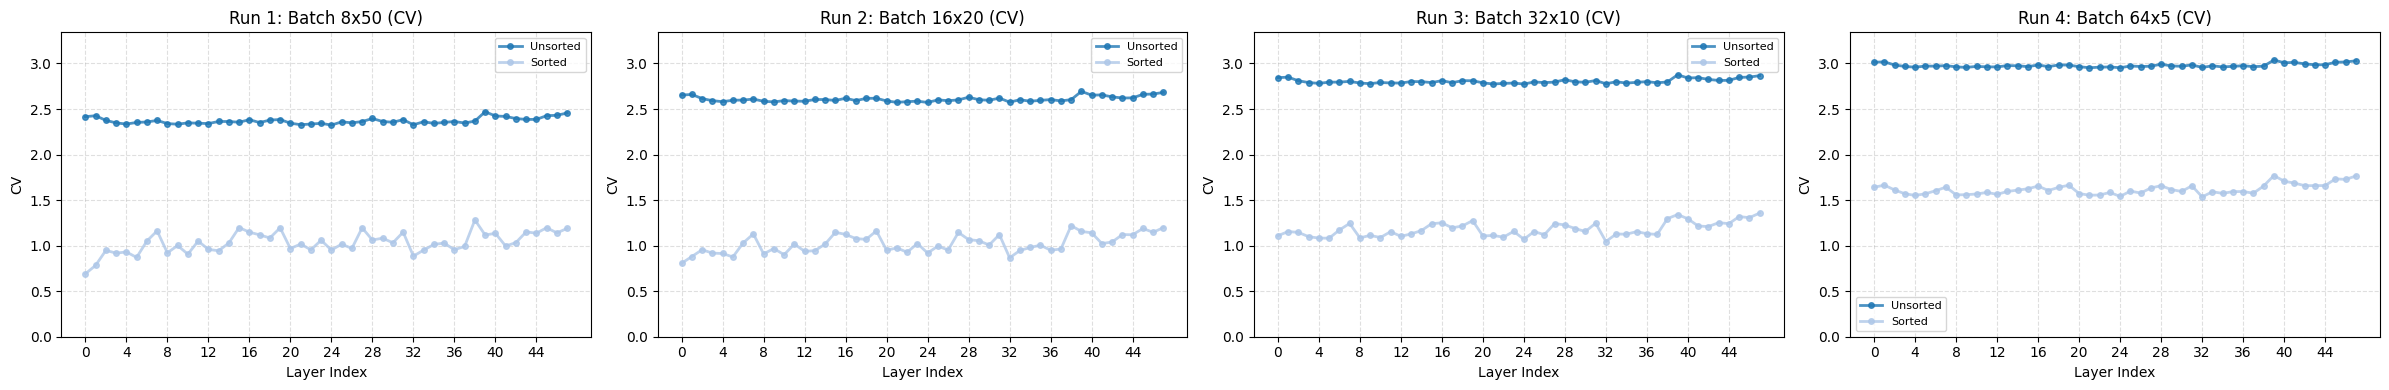

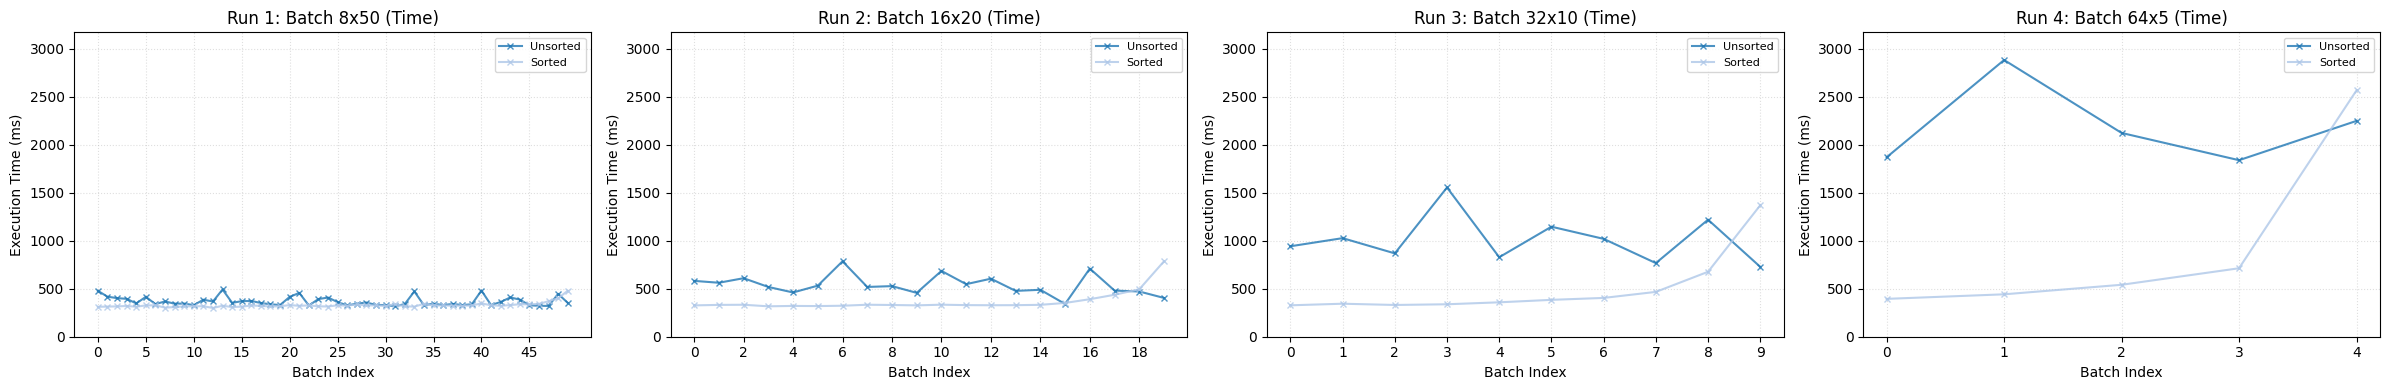

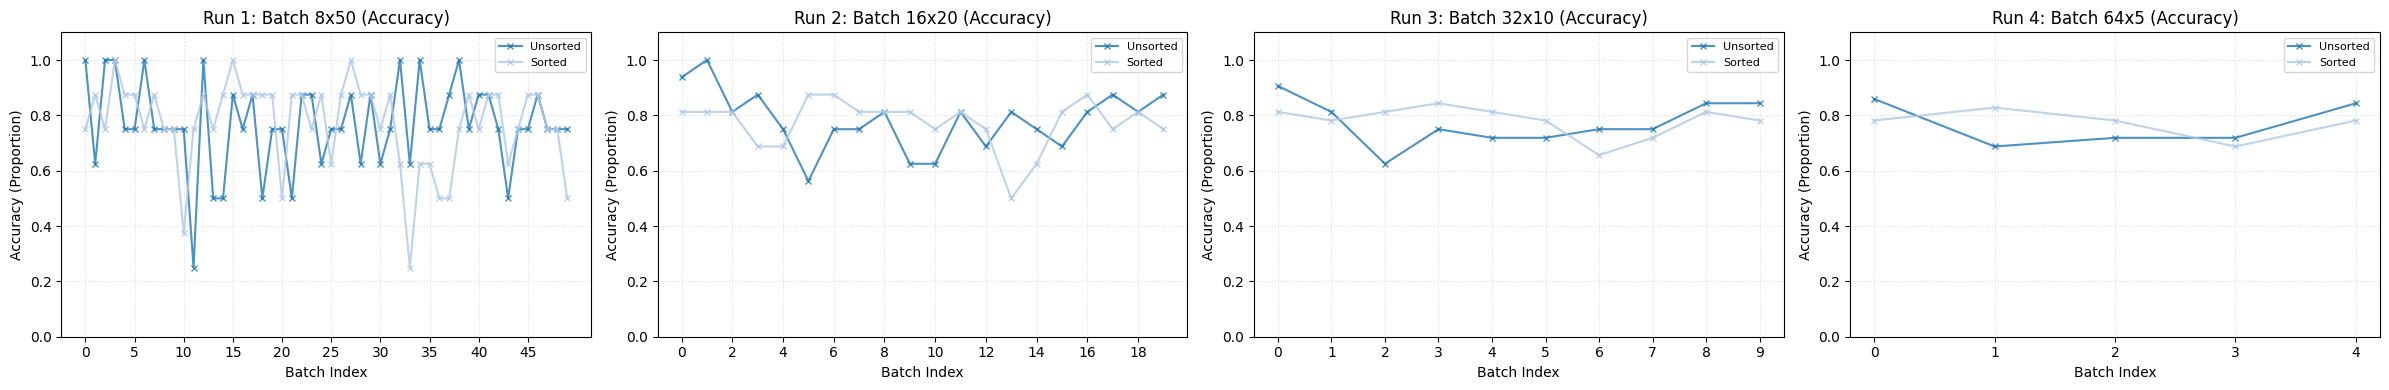

In [ ]:
# ensure model forward is restored to original
restore_forward(model)

evals = ["Unsorted", "Sorted"]
is_sorted = [False, True]
is_opt = [False, False]

runs = [
    # batch size powers of 2, num batches decreasing
    BatchRun(evals, is_sorted, is_opt, batch_size=8, num_batches=50),
    BatchRun(evals, is_sorted, is_opt, batch_size=16, num_batches=20),
    BatchRun(evals, is_sorted, is_opt, batch_size=32, num_batches=10),
    BatchRun(evals, is_sorted, is_opt, batch_size=64, num_batches=5),
]

initial_eval = Evaluation(model, tokenizer, runs)
initial_eval.evaluate()

initial_cv_plot_fig, initial_cv_plot_ax = initial_eval.plot_cv(cols=4)
initial_timing_plot_fig, initial_timing_plot_ax = initial_eval.plot_batch_times(cols=4)
initial_acc_plot_fig, initial_acc_plot_ax = initial_eval.plot_accuracies(cols=4)

### Final Evaluation (Optimized vs Baseline)

Restored original forward for 0 MoE blocks
Model has no hooks

============Begin run 1 (Batch=8x50)============

------------Begin eval Unsorted (Unoptimized)------------
Monitoring 48 MoE layers (gate)
Removed all handles

------------Begin eval Sorted (Unoptimized)------------
Monitoring 48 MoE layers (gate)
Removed all handles

------------Begin eval Unsorted (Optimized)------------
Monitoring 48 MoE layers (mlp)
Swapped forward for 48 MoE blocks
Restored original forward for 48 MoE blocks
Removed all handles

------------Begin eval Sorted (Optimized)------------
Monitoring 48 MoE layers (mlp)
Swapped forward for 48 MoE blocks
Restored original forward for 48 MoE blocks
Removed all handles

============Begin run 2 (Batch=16x20)============

------------Begin eval Unsorted (Unoptimized)------------
Monitoring 48 MoE layers (gate)
Removed all handles

------------Begin eval Sorted (Unoptimized)------------
Monitoring 48 MoE layers (gate)
Removed all handles

------------Begin eval Uns

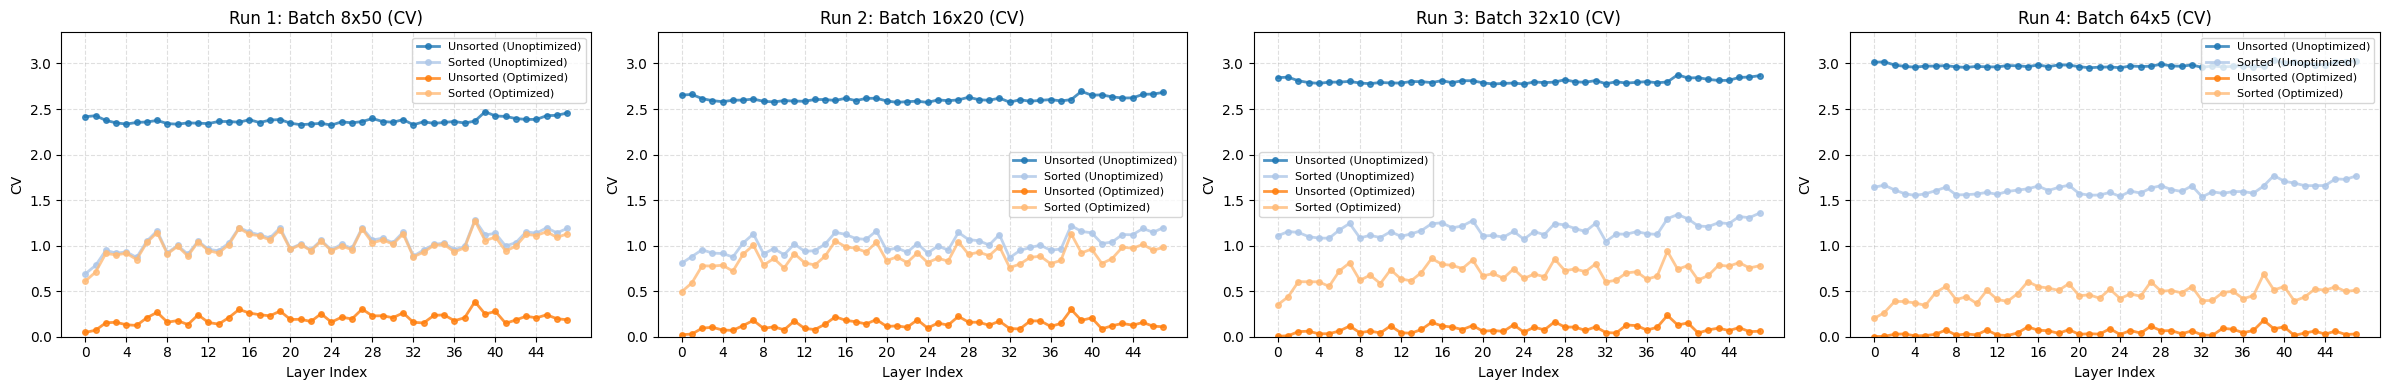

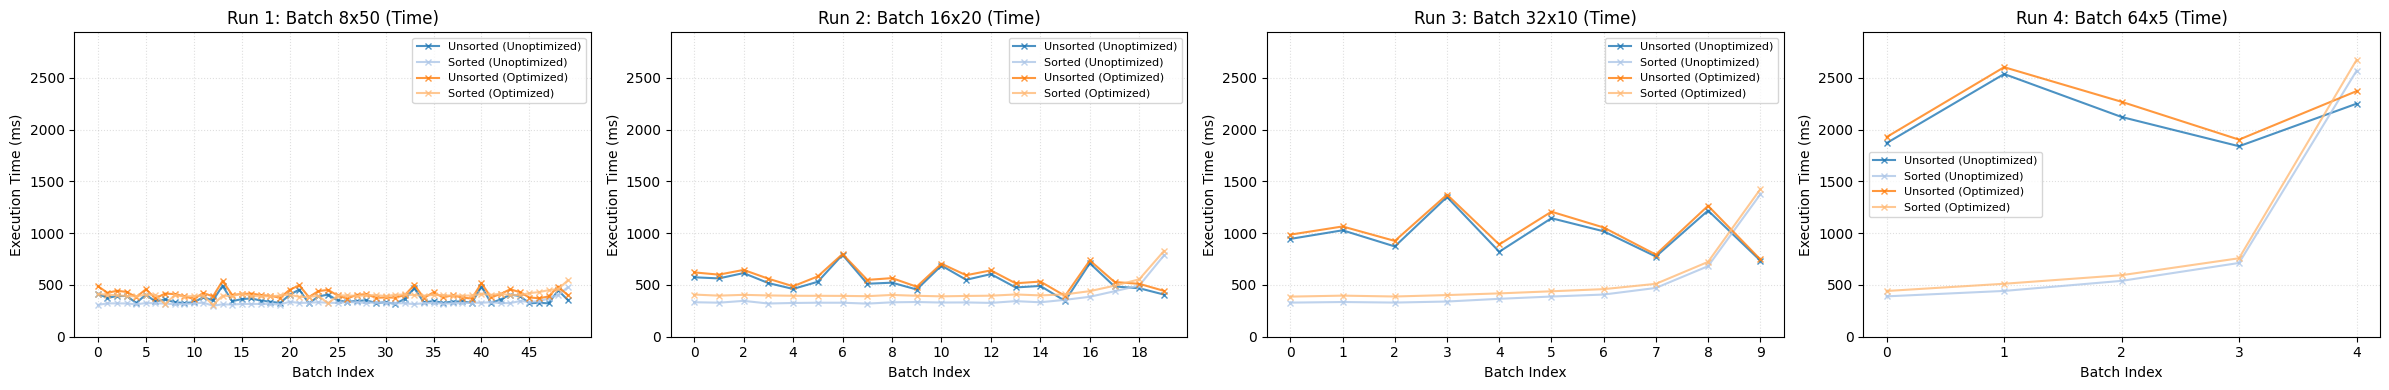

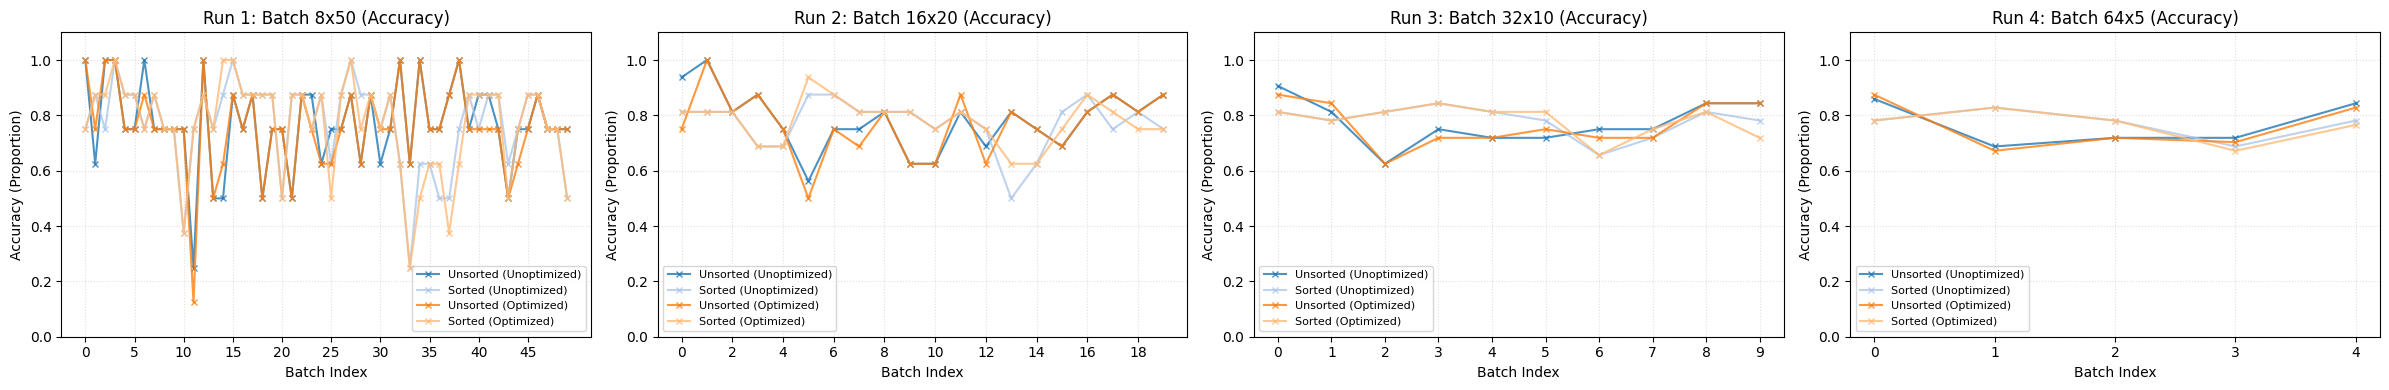

In [ ]:
# ensure model forward is restored to original
restore_forward(model)

evals = ["Unsorted (Unoptimized)", "Sorted (Unoptimized)", "Unsorted (Optimized)", "Sorted (Optimized)"]
is_sorted = [False, True, False, True]
is_opt = [False, False, True, True]

runs = [
    # batch size powers of 2, num batches decreasing
    BatchRun(evals, is_sorted, is_opt, batch_size=8, num_batches=50),
    BatchRun(evals, is_sorted, is_opt, batch_size=16, num_batches=20),
    BatchRun(evals, is_sorted, is_opt, batch_size=32, num_batches=10),
    BatchRun(evals, is_sorted, is_opt, batch_size=64, num_batches=5),
]

final_eval = Evaluation(model, tokenizer, runs)
final_eval.evaluate()

final_cv_plot_fig, final_cv_plot_ax = final_eval.plot_cv(cols=4)
final_timing_plot_fig, final_timing_plot_ax = final_eval.plot_batch_times(cols=4)
final_acc_plot_fig, final_acc_plot_ax = final_eval.plot_accuracies(cols=4)

### Save Evaluation Plots

In [ ]:
initial_cv_plot_fig.savefig('initial_cv_plots.png', dpi=300, bbox_inches='tight')
initial_timing_plot_fig.savefig('initial_timing_plots.png', dpi=300, bbox_inches='tight')
initial_acc_plot_fig.savefig('initial_accuracy_plots.png', dpi=300, bbox_inches='tight')

final_cv_plot_fig.savefig('final_cv_plots.png', dpi=300, bbox_inches='tight')
final_timing_plot_fig.savefig('final_timing_plots.png', dpi=300, bbox_inches='tight')
final_acc_plot_fig.savefig('final_accuracy_plots.png', dpi=300, bbox_inches='tight')

## Generate Visuals

### Visualize Padding Tokens in Batch
- note that for one batch, sorting does not change padding token count

unsorted_batch_1_of_3.png
Num padding tokens: 2354
pad_perc=tensor(62.6064)
unsorted_batch_2_of_3.png
Num padding tokens: 2117
pad_perc=tensor(59.8023)
unsorted_batch_3_of_3.png
Num padding tokens: 2602
pad_perc=tensor(71.0929)
sorted_batch_1_of_3.png
Num padding tokens: 221
pad_perc=tensor(32.9851)
sorted_batch_2_of_3.png
Num padding tokens: 291
pad_perc=tensor(24.0496)
sorted_batch_3_of_3.png
Num padding tokens: 1241
pad_perc=tensor(33.0053)


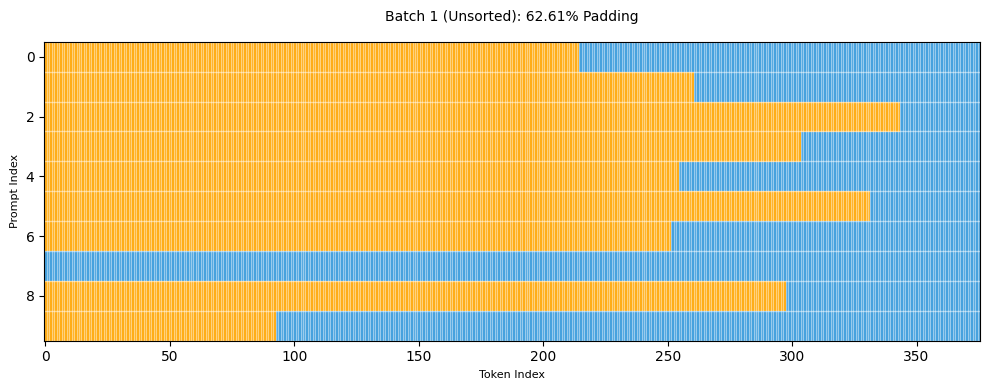

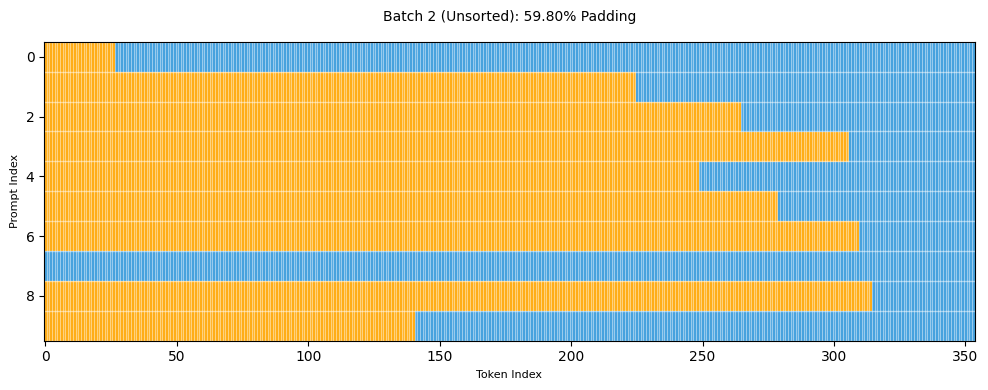

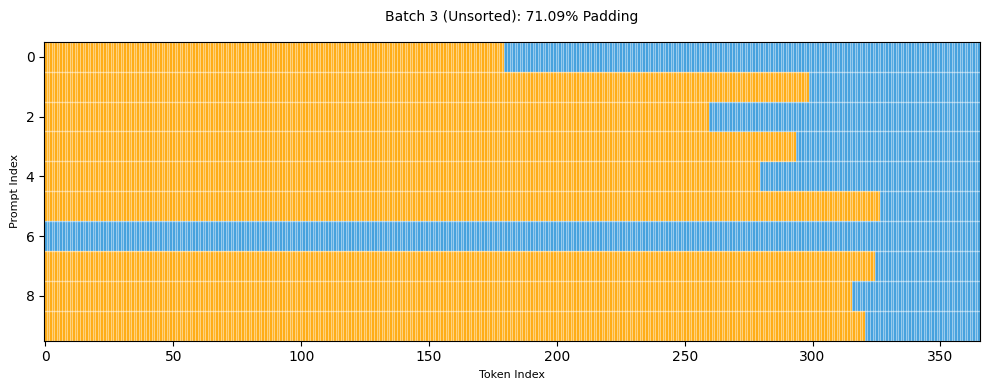

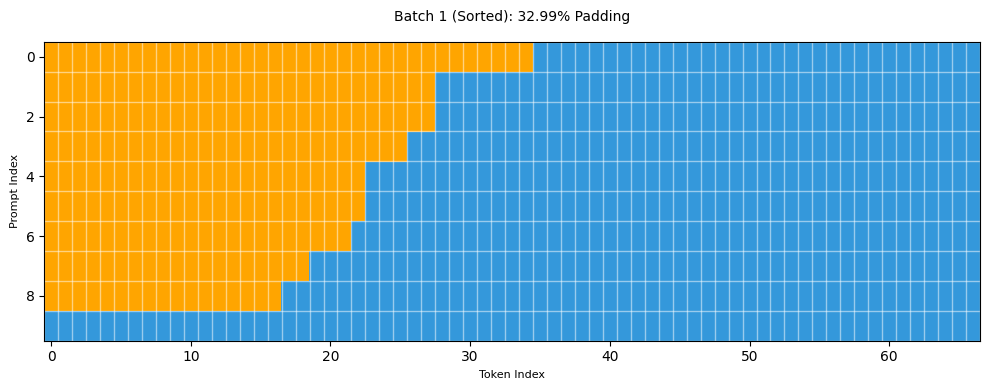

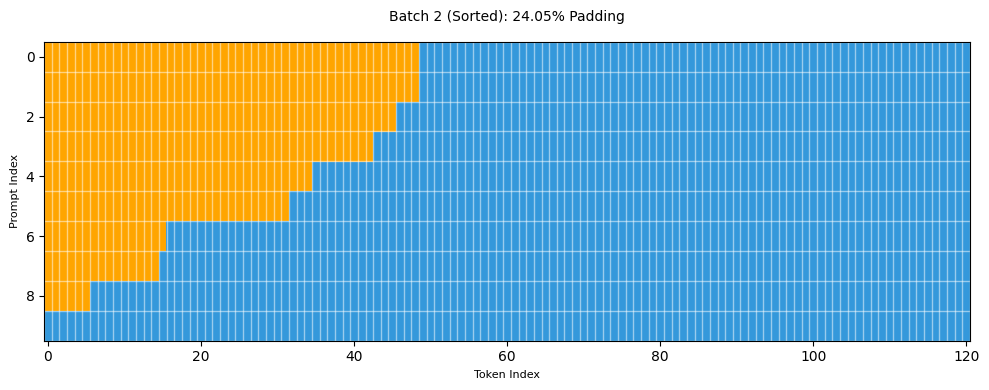

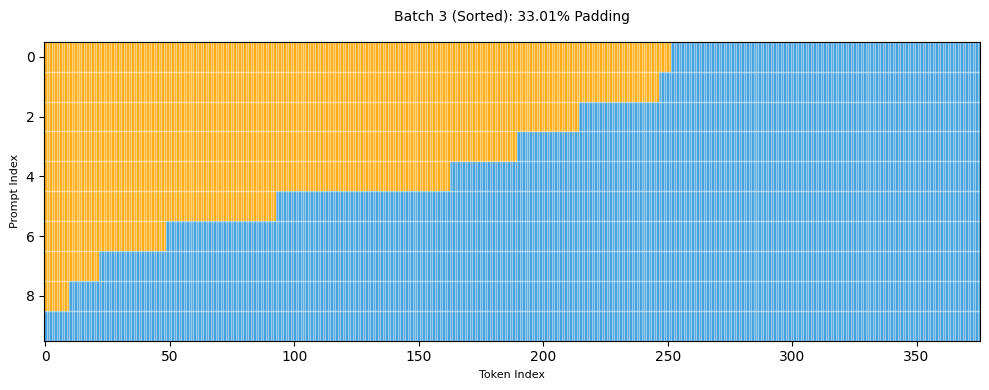

In [ ]:
def visualize_padding(attention_mask: torch.Tensor, batch_idx: int, sorted: bool, pad_perc: int, save_path: str = "padding_map.png"):
    """
    creates a grid visualization of real vs padding tokens in a batch
    attention_mask: Tensor of shape (batch_size, seq_len)
    """
    # convert tensor to numpy
    mask_data = attention_mask.detach().cpu().numpy()
    batch_size, seq_len = mask_data.shape

    # use orange for padding and blue for real tokens
    cmap = ListedColormap(['#ffa500', '#3498db'])

    # set plot size
    plt.figure(figsize=(10,4))

    # create plot
    plt.imshow(mask_data, aspect='auto', cmap=cmap, interpolation='nearest')

    # add grid lines to make token boundaries distinct
    plt.gca().set_xticks(np.arange(-.5, seq_len, 1), minor=True)
    plt.gca().set_yticks(np.arange(-.5, batch_size, 1), minor=True)
    plt.grid(which="minor", color="w", linestyle='-', linewidth=1, alpha=0.5)
    plt.tick_params(which="minor", bottom=False, left=False)

    # labeling
    plt.title(f'Batch {batch_idx} ({"Sorted" if sorted else "Unsorted"}): {pad_perc:.2f}% Padding', fontsize=10, pad=15)
    plt.xlabel('Token Index', fontsize=8)
    plt.ylabel('Prompt Index', fontsize=8)

    # create custom legend
    # from matplotlib.patches import Patch
    # legend_elements = [
    #     Patch(facecolor='#3498db', label='Real Token'),
    #     Patch(facecolor='#ffa500', label='Padding Token')
    # ]
    # plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.2, 1))

    # save output
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

model_name = "Qwen/Qwen3-30B-A3B"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# load batches from dataset
batch_size = 10
num_batches = 3
full_subset = load_mmlu_subset(sample_size=batch_size * num_batches)

# create sorted and unsorted batches
batch_indices = get_length_grouped_batches(full_subset, tokenizer, batch_size=batch_size)
sorted_batches = [[full_subset[i] for i in indices] for indices in batch_indices]
unsorted_batches = [[full_subset[i * batch_size + j] for j in range(batch_size)] for i in range(num_batches)]

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

# visualize unsorted batches
for i, batch in enumerate(unsorted_batches):
    prompts = [format_mmlu_prompt(ex) for ex in batch]
    inputs = tokenizer(prompts, return_tensors="pt", padding=True)

    save_name = f"unsorted_batch_{i+1}_of_{num_batches}.png"
    print(save_name)

    num_pad_tok = (inputs["attention_mask"] == 0).sum()
    print(f"Num padding tokens: {num_pad_tok}")
    pad_perc = num_pad_tok / torch.ones_like(inputs["attention_mask"]).sum() * 100
    print(f"{pad_perc=}")

    visualize_padding(
        inputs["attention_mask"],
        batch_idx=i+1,
        sorted=False,
        pad_perc=pad_perc,
        save_path=save_name
    )

# visualize sorted batches
for i, batch in enumerate(sorted_batches):
    prompts = [format_mmlu_prompt(ex) for ex in batch]
    inputs = tokenizer(prompts, return_tensors="pt", padding=True)

    save_name = f"sorted_batch_{i+1}_of_{num_batches}.png"
    print(save_name)

    num_pad_tok = (inputs["attention_mask"] == 0).sum()
    print(f"Num padding tokens: {num_pad_tok}")
    pad_perc = num_pad_tok / torch.ones_like(inputs["attention_mask"]).sum() * 100
    print(f"{pad_perc=}")

    visualize_padding(
        inputs["attention_mask"],
        batch_idx=i+1,
        sorted=True,
        pad_perc=pad_perc,
        save_path=save_name
    )


### Visualize Pad Token Redistribution

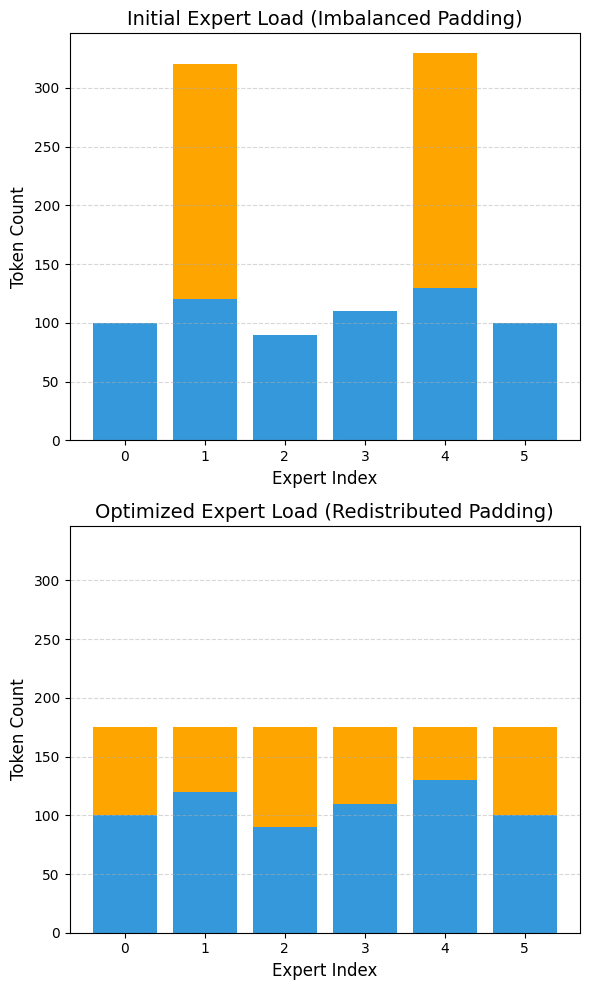

In [ ]:
# 6 experts, top-k = 2
experts = np.arange(6)
expert_labels = [f'Expert {i}' for i in experts]

# initial "real" token counts
real_tokens = np.array([100, 120, 90, 110, 130, 100])

# initial padding tokens
pad_tokens_initial = np.array([0, 200, 0, 0, 200, 0])

# calculate totals
total_real = np.sum(real_tokens)
total_pad = np.sum(pad_tokens_initial)
total_tokens_global = total_real + total_pad
num_experts = len(experts)
target_avg = total_tokens_global / num_experts

pad_tokens_optimized = np.zeros_like(real_tokens)

# get balanced pad token counts
for i in range(num_experts):
    needed = target_avg - real_tokens[i]
    pad_tokens_optimized[i] = needed

fig, axes = plt.subplots(2, 1, figsize=(6, 10), sharey=True)

color_real = '#3498db'
color_pad = '#ffa500'

# plot initial load
axes[0].bar(experts, real_tokens, color=color_real, label='Real Tokens')
axes[0].bar(experts, pad_tokens_initial, bottom=real_tokens, color=color_pad, label='Pad Tokens')
axes[0].set_title('Initial Expert Load (Imbalanced Padding)', fontsize=14)
axes[0].set_ylabel('Token Count', fontsize=12)
axes[0].set_xlabel('Expert Index', fontsize=12)
axes[0].set_xticks(experts)
axes[0].grid(axis='y', linestyle='--', alpha=0.5)
# axes[0].legend()

# plot optimized load
axes[1].bar(experts, real_tokens, color=color_real, label='Real Tokens')
axes[1].bar(experts, pad_tokens_optimized, bottom=real_tokens, color=color_pad, label='Pad Tokens')
axes[1].set_title('Optimized Expert Load (Redistributed Padding)', fontsize=14)
axes[1].set_ylabel('Token Count', fontsize=12)
axes[1].set_xlabel('Expert Index', fontsize=12)
axes[1].set_xticks(experts)
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

# plt.suptitle('MoE Batch Inference: Padding Token Redistribution Optimization', fontsize=16)
plt.tight_layout()
plt.show()

## [ARCHIVED] Plot Per-Layer Per-Expert Token Distributions

### Run Inference on Sample Text

In [ ]:
warmup(model, tokenizer)

# remove all existing hooks so there are no conflicts
remove_all_hooks(model)
list_hooks(model)

# initialize monitors
monitor = {
    "batch_unsorted": MoEMonitor(model),
    "batch_sorted": MoEMonitor(model),
    "online": MoEMonitor(model)
}

# load repeatable subset from dataset
subset_size = 32
num_subsets = 10
full_subset = load_mmlu_subset(sample_size=subset_size * num_subsets)

# get length optimized indices
batch_indices = get_length_grouped_batches(full_subset, tokenizer, batch_size=subset_size)
sorted_subsets = [[full_subset[i] for i in indices] for indices in batch_indices]
unsorted_subsets = [[full_subset[i * subset_size + j] for j in range(subset_size)] for i in range(num_subsets)]

# initialize accuracy metrics
correct_count = {
    "batch_unsorted": 0,
    "batch_sorted": 0,
    "online": 0
}

# batch inference unsorted
print(f"\nBegin UNSORTED batch inference ({subset_size=}, {num_subsets=})")
monitor["batch_unsorted"].attach()

total_batch_times = torch.zeros(num_subsets)
for i, subset in enumerate(unsorted_subsets): # unsorted subsets
    choices, total_batch_time = evaluate_batch(subset, model, tokenizer)
    total_batch_times[i] = total_batch_time
    correct_count["batch_unsorted"] += sum([1 for i, example in enumerate(subset) if ["A", "B", "C", "D"][example['answer']] == choices[i]])
print(f"\n(Batch) Final Accuracy: {correct_count["batch_unsorted"]/(len(subset) * num_subsets):.2%}")
print(f"(Batch) Average Total Batch Time: {total_batch_time:.2f} ms") # ISSUE: not using total_batch_times

monitor["batch_unsorted"].remove()

# batch inference sorted
print(f"\nBegin SORTED batch inference ({subset_size=}, {num_subsets=})")
monitor["batch_sorted"].attach()

total_batch_times = torch.zeros(num_subsets)
for i, subset in enumerate(sorted_subsets): # sorted subsets
    choices, total_batch_time = evaluate_batch(subset, model, tokenizer)
    total_batch_times[i] = total_batch_time
    correct_count["batch_sorted"] += sum([1 for i, example in enumerate(subset) if ["A", "B", "C", "D"][example['answer']] == choices[i]])
print(f"\n(Batch) Final Accuracy: {correct_count["batch_sorted"]/(len(subset) * num_subsets):.2%}")
print(f"(Batch) Average Total Batch Time: {total_batch_time:.2f} ms") # ISSUE: not using total_batch_times

monitor["batch_sorted"].remove()

# online (non-batch) inference
print(f"\nBegin online inference ({subset_size=}, {num_subsets=})")
monitor["online"].attach()

ttfts = torch.zeros(subset_size)
for subset_idx, subset in enumerate(sorted_subsets): # sorted subsets
    # print(f"begin subset {subset_idx}")
    for i, example in enumerate(subset):
        ground_truth = ["A", "B", "C", "D"][example['answer']]

        pred, ttft = evaluate_online(example, model, tokenizer)
        ttfts[i] = ttft

        is_correct = (pred == ground_truth)
        if is_correct: correct_count["online"] += 1

        # print(f"[{i+1}] Pred: {pred} | Actual: {ground_truth} | {'✅' if is_correct else '❌'}")
print(f"\n(Online) Final Accuracy: {correct_count["online"]/(len(subset) * num_subsets):.2%}")
print(f"(Online) Average TTFT: {ttfts.mean():.2f} ms")

monitor["online"].remove()

Model has no hooks

Begin UNSORTED batch inference (subset_size=32, num_subsets=10)
Monitoring 48 MoE layers (gate)

(Batch) Final Accuracy: 77.19%
(Batch) Average Total Batch Time: 724.46 ms
Removed all handles

Begin SORTED batch inference (subset_size=32, num_subsets=10)
Monitoring 48 MoE layers (gate)

(Batch) Final Accuracy: 78.12%
(Batch) Average Total Batch Time: 1371.27 ms
Removed all handles

Begin online inference (subset_size=32, num_subsets=10)
Monitoring 48 MoE layers (gate)

(Online) Final Accuracy: 75.94%
(Online) Average TTFT: 291.87 ms
Removed all handles


### Compare Coefficients of Variation (CVs)

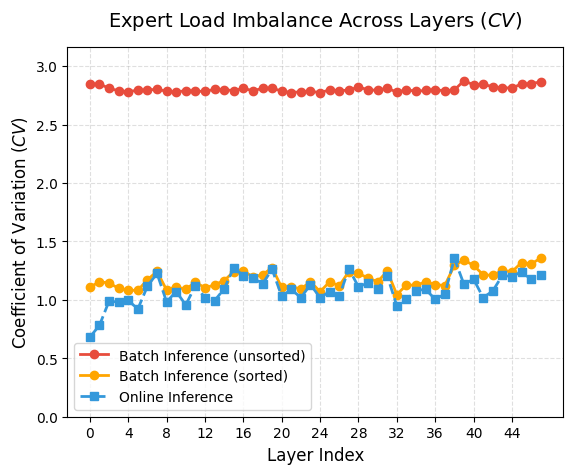

In [ ]:
num_layers = model.config.num_hidden_layers
batch_unsorted_cvs = [monitor["batch_unsorted"].stats.get_layer_imbalance(layer_idx=i).item() for i in range(num_layers)]
batch_sorted_cvs = [monitor["batch_sorted"].stats.get_layer_imbalance(layer_idx=i).item() for i in range(num_layers)]
online_cvs = [monitor["online"].stats.get_layer_imbalance(layer_idx=i).item() for i in range(num_layers)]

plt.plot(range(num_layers), batch_unsorted_cvs, label='Batch Inference (unsorted)', color='#e74c3c', marker='o', linewidth=2)
plt.plot(range(num_layers), batch_sorted_cvs, label='Batch Inference (sorted)', color='#ffa500', marker='o', linewidth=2)
plt.plot(range(num_layers), online_cvs, label='Online Inference', color='#3498db', marker='s', linestyle='--', linewidth=2)

plt.title('Expert Load Imbalance Across Layers ($CV$)', fontsize=14, pad=15)
plt.xlabel('Layer Index', fontsize=12)
plt.ylabel('Coefficient of Variation ($CV$)', fontsize=12)
plt.legend(frameon=True)
plt.grid(True, which='both', linestyle='--', alpha=0.4)

plt.ylim(0, max(max(batch_unsorted_cvs), max(batch_sorted_cvs), max(online_cvs)) * 1.1)
plt.xticks(range(0, num_layers, max(1, num_layers // 10)))

plt.savefig(f'moe_cv_comparison_batch_{subset_size}_x{num_subsets}.png', dpi=300, bbox_inches='tight')

### Visualize Distribution
- heatmap for unsorted batch inference is more polarized due to padding tokens being routed to the same set of 8 experts
- heatmap for sorted batch inference is much closer (if not better than!?) ground truth
- heatmap for online inference is used as ground truth because there are no padding tokens

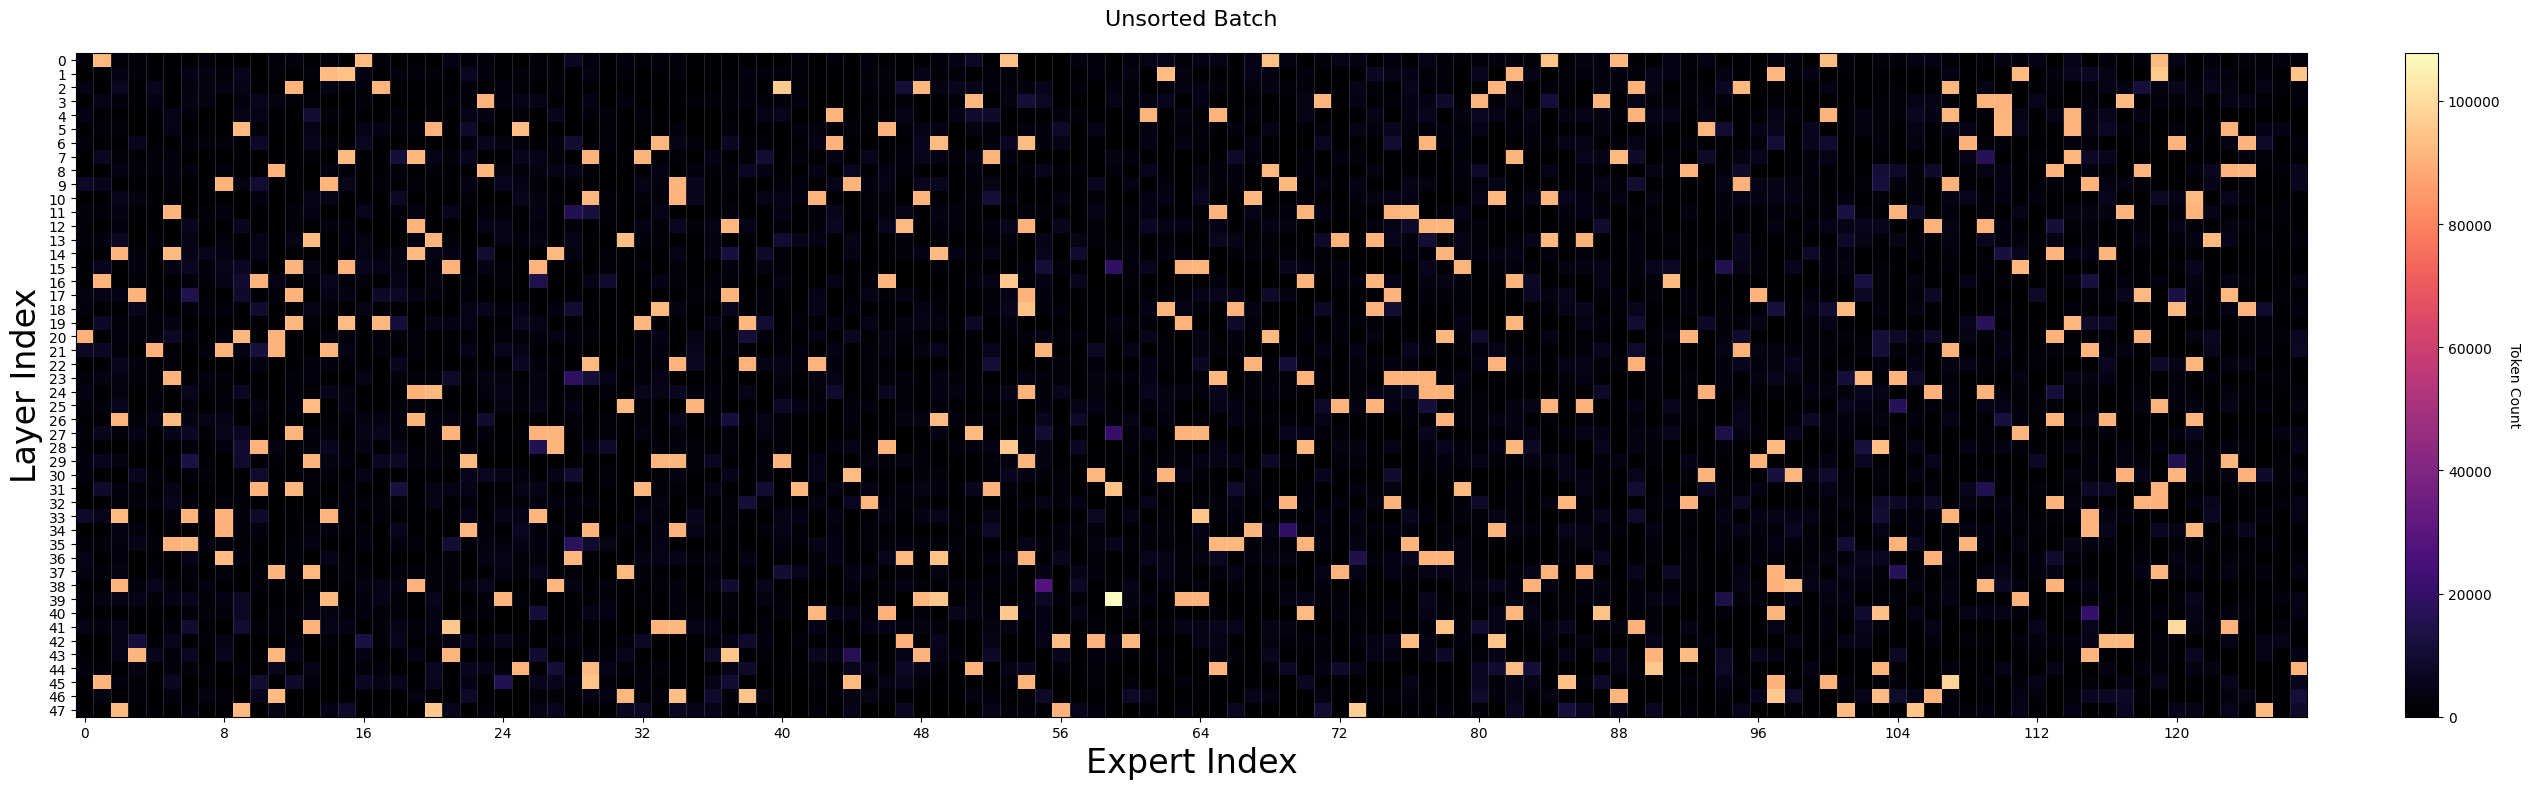

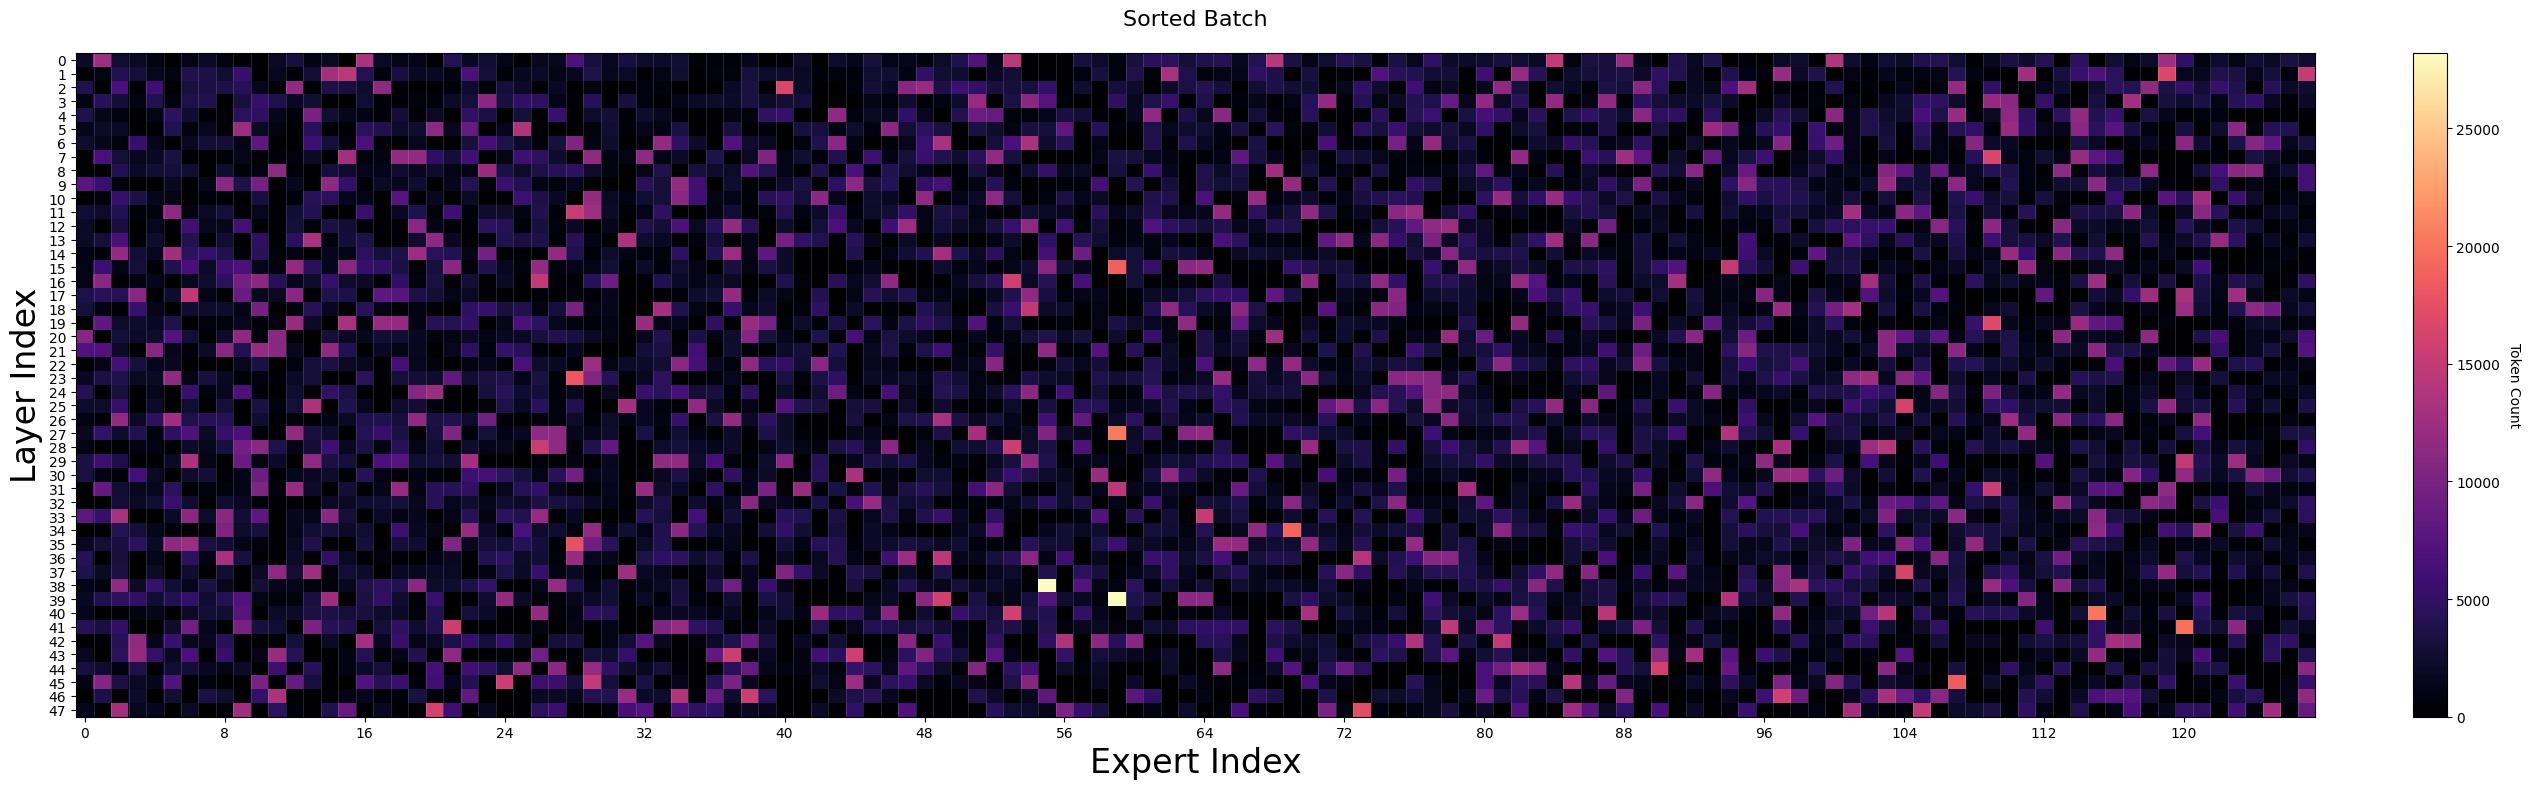

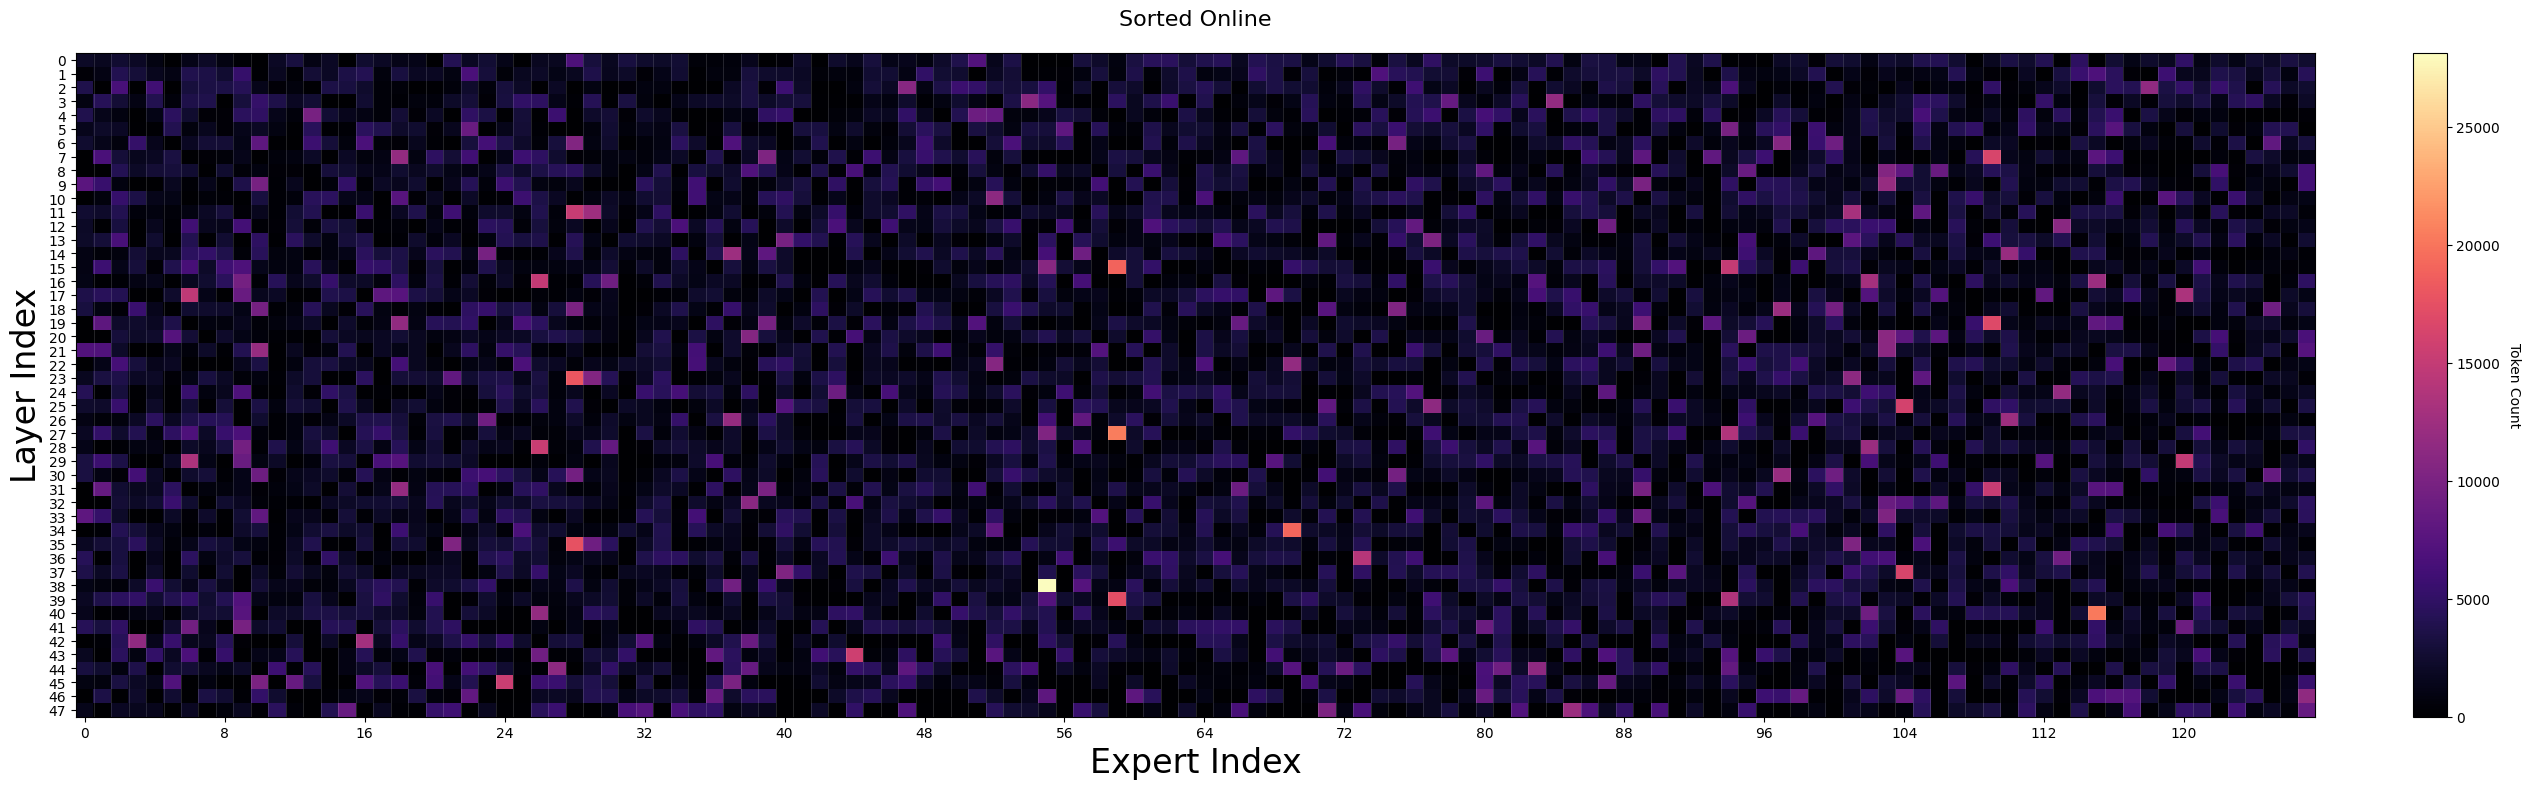

In [ ]:
monitor["batch_unsorted"].stats.plot_heatmap(title=f"Unsorted Batch", save_path=f"batch_inf_unsorted_{subset_size}x{num_subsets}")
monitor["batch_sorted"].stats.plot_heatmap(title=f"Sorted Batch", save_path=f"batch_inf_sorted_{subset_size}x{num_subsets}")
monitor["online"].stats.plot_heatmap(title=f"Sorted Online", save_path=f"online_inf_sorted_{subset_size}x{num_subsets}")